# Plot MTF50 as a function of aperture and defocus, for illustration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
with open('./mtfs/f6_mtf.pickle', 'rb') as f:
    f6_freqs, f6_pos, f6_MTF = pickle.load(f)
with open('./mtfs/f11_mtf.pickle', 'rb') as f:
    f11_freqs, f11_pos, f11_MTF = pickle.load(f)
with open('./mtfs/f17_mtf.pickle', 'rb') as f:
    f17_freqs, f17_pos, f17_MTF = pickle.load(f)
with open('./mtfs/f26_mtf.pickle', 'rb') as f:
    f26_freqs, f26_pos, f26_MTF = pickle.load(f)
with open('./MTF_NO_BG_SUBTRACT/mtfs/f47_mtf.pickle', 'rb') as f:
    f47_freqs, f47_pos, f47_MTF = pickle.load(f)

## In-focus MTF as a function of aperture

Expect resolution to scale proportionally with NA

In [3]:
# dataframes for in-focus mtfs, to make searching easier
f6_df = pd.DataFrame({'freqs': f6_freqs, 'mtf': f6_MTF[12]})
f11_df = pd.DataFrame({'freqs': f11_freqs, 'mtf': f11_MTF[12]})
f17_df = pd.DataFrame({'freqs': f17_freqs, 'mtf': f17_MTF[12]})
f26_df = pd.DataFrame({'freqs': f26_freqs, 'mtf': f26_MTF[12]})
f47_df = pd.DataFrame({'freqs': f47_freqs, 'mtf': f47_MTF[12]})

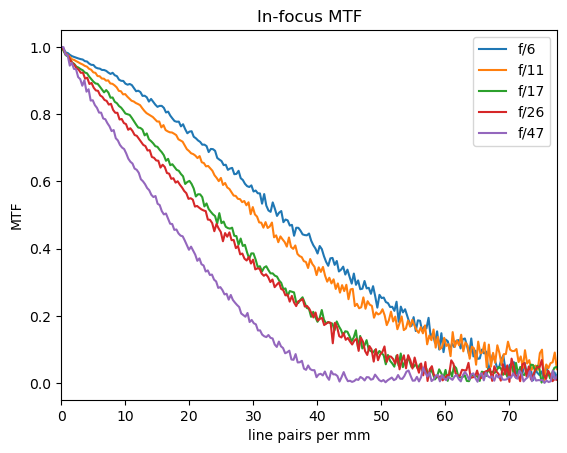

In [4]:
plt.plot(f6_freqs, f6_MTF[12], label='f/6')
plt.plot(f11_freqs, f11_MTF[12], label='f/11')
plt.plot(f17_freqs, f17_MTF[12], label='f/17')
plt.plot(f26_freqs, f26_MTF[12], label='f/26')
plt.plot(f47_freqs, f47_MTF[12], label='f/47')
plt.xlim(0, 0.5 / 6.45e-3)
plt.xlabel("line pairs per mm")
plt.ylabel("MTF")
plt.title('In-focus MTF')
plt.legend()
plt.savefig('infocus-mtf-vs-aperture.png', transparent=True, dpi=300)
plt.show()

In [5]:
print(f6_df.iloc[(f6_df['mtf']-0.5).abs().argsort()[:1]])
print(f11_df.iloc[(f11_df['mtf']-0.5).abs().argsort()[:1]])
print(f17_df.iloc[(f17_df['mtf']-0.5).abs().argsort()[:1]])
print(f26_df.iloc[(f26_df['mtf']-0.5).abs().argsort()[:1]])
print(f47_df.iloc[(f47_df['mtf']-0.5).abs().argsort()[:1]])

        freqs       mtf
101  33.69637  0.497552
        freqs       mtf
91  30.244152  0.501998
        freqs       mtf
71  23.681653  0.502411
        freqs       mtf
67  22.554108  0.511817
        freqs       mtf
49  16.014274  0.502032


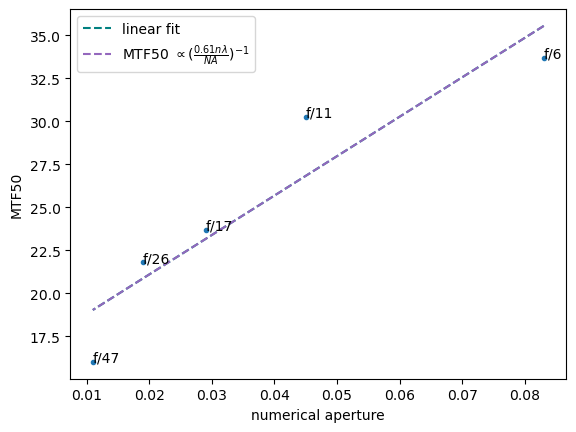

In [6]:
apertures = [0.083, 0.045, 0.029, 0.019, 0.011] # using approx NA = 1/(2*f-number) in air, at small angle
labels = ['f/6', 'f/11', 'f/17', 'f/26', 'f/47']
mtf50s = [33.69637, 30.244152, 23.681653, 21.795757, 16.014274]

plt.plot(apertures, mtf50s, '.')

for i, txt in enumerate(labels):
    plt.gca().annotate(txt, (apertures[i], mtf50s[i]))

def f(x, A, B):
    return A*x + B

def airy(NA, A, B):
    return (A / (0.61 * 562e-9 / NA)) + B

popt, pcov = curve_fit(f, apertures, mtf50s)
plt.plot(apertures, f(np.array(apertures), *popt), '--', color='teal', label='linear fit')
popt, pcov = curve_fit(airy, apertures, mtf50s)
plt.plot(apertures, airy(np.array(apertures), *popt), '--', color='tab:purple', label=r'MTF50 $\propto (\frac{0.61 n \lambda}{NA})^{-1}$')

plt.xlabel('numerical aperture')
plt.ylabel('MTF50')
plt.legend()
plt.show()

## Depth of field as function of aperture

Expect to scale inversely with square of NA

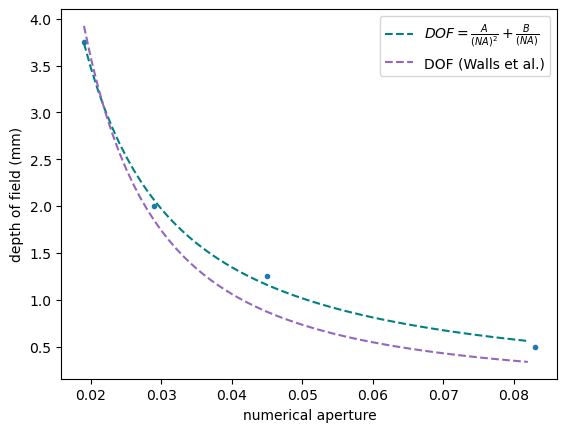

In [7]:
apertures = [0.083, 0.045, 0.029, 0.019] # using approx NA = 1/(2*f-number) in air, at small angle
labels = ['f/6', 'f/11', 'f/17', 'f/26']
dofs = [0.5, 1.25, 2.0, 3.75]

plt.plot(apertures, dofs, '.')

# for i, txt in enumerate(labels):
#     plt.gca().annotate(txt, (apertures[i], dofs[i]), xytext=(5, 5), textcoords='offset points')

def f(x, A, B):
    return A/x**2 + B/x

def dof(NA, A):
    return A*(1.33 * (((562e-9)/(NA)**2) + ((6.45e-6)/(NA))))*1e3

na_forplot = np.arange(start=0.019, stop=0.083, step=0.001)

popt, pcov = curve_fit(f, apertures, dofs)
plt.plot(na_forplot, f(na_forplot, *popt), '--', color='teal', label=r'$DOF = \frac{A}{(NA)^2} + \frac{B}{(NA)}$')
popt, pcov = curve_fit(dof, apertures, dofs)
plt.plot(na_forplot, dof(na_forplot, *popt), '--', color='tab:purple', label='DOF (Walls et al.)')

plt.xlabel('numerical aperture')
plt.ylabel('depth of field (mm)')
plt.savefig('dof-vs-na.png', transparent=True, dpi=300)
plt.legend()
plt.show()

Mismatch probably due to different definition of depth of field? Maybe just have to show proportionality...

## MTF50 vs defocus at each aperture

In [8]:
f6_mtf_50s = []
for i in range(len(f6_MTF)):
    df = pd.DataFrame({'freqs': f6_freqs, 'mtf': f6_MTF[i]})
    mtf_50 = df.iloc[(df['mtf']-0.5).abs().argsort()[:1]]['freqs']
    f6_mtf_50s.append(mtf_50)

f11_mtf_50s = []
for i in range(len(f11_MTF)):
    df = pd.DataFrame({'freqs': f11_freqs, 'mtf': f11_MTF[i]})
    mtf_50 = df.iloc[(df['mtf']-0.5).abs().argsort()[:1]]['freqs']
    f11_mtf_50s.append(mtf_50)

f17_mtf_50s = []
for i in range(len(f17_MTF)):
    df = pd.DataFrame({'freqs': f17_freqs, 'mtf': f17_MTF[i]})
    mtf_50 = df.iloc[(df['mtf']-0.5).abs().argsort()[:1]]['freqs']
    f17_mtf_50s.append(mtf_50)

f26_mtf_50s = []
for i in range(len(f26_MTF)):
    df = pd.DataFrame({'freqs': f26_freqs, 'mtf': f26_MTF[i]})
    mtf_50 = df.iloc[(df['mtf']-0.5).abs().argsort()[:1]]['freqs']
    f26_mtf_50s.append(mtf_50)

f47_mtf_50s = []
for i in range(len(f47_MTF)):
    df = pd.DataFrame({'freqs': f47_freqs, 'mtf': f47_MTF[i]})
    mtf_50 = df.iloc[(df['mtf']-0.5).abs().argsort()[:1]]['freqs']
    f47_mtf_50s.append(mtf_50)

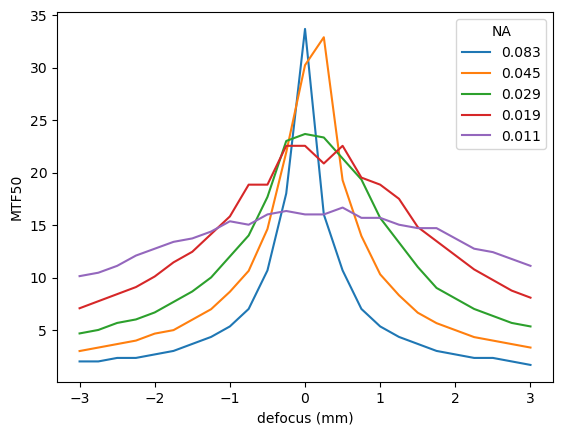

In [9]:
plt.plot(f6_pos, f6_mtf_50s, label='0.083')
plt.plot(f11_pos, f11_mtf_50s, label='0.045')
plt.plot(f17_pos, f17_mtf_50s, label='0.029')
plt.plot(f26_pos, f26_mtf_50s, label='0.019')
plt.plot(f47_pos, f47_mtf_50s, label='0.011')
plt.legend(title='NA')
plt.xlabel('defocus (mm)')
plt.ylabel('MTF50')
plt.savefig('mtf50-vs-aperture.png', transparent=True, dpi=300)
plt.show()